# Language Generation Models Assessment Tool Demo
Language generation models generate meaningful text when prompted with a sequence of words as context. These models now empower
many downstream applications from conversation bots to automatic storytelling ([Dhamala et al. 2021](https://arxiv.org/pdf/2101.11718.pdf)). 

Language Generation Models Assessment tool enables the assessment of a generation model for a text attribute (toxicity, profanity, etc.) and disparate impact. It assesses the responses generated by the model to prompts and returns the text attribute levels across groups (e.g., islam and christianity). The tool has a variety of prompts datasets and text assessment models built in, but is also highly flexible and allows a user to provide their own datasets and models when desired. 

### Install required packages

This package requires extra insllations. Please run
```
pip install credoai-lens[extras]
```
or uncomment the below to install.

In [1]:
# %pip install --upgrade transformers
# %pip install --upgrade sentence_transformers
# %pip install --upgrade google-api-python-client

In [2]:
import pandas as pd
import matplotlib
from credoai.modules.model_assessments.nlp_generator import NLPGeneratorAnalyzer
from transformers import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer, GPT2LMHeadModel, GPT2Tokenizer

%matplotlib inline
pd.set_option('display.expand_frame_repr', False)

### Define text generation function(s)
[GPT-1](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf) and [GPT-2](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) from OpenAI are assessed now. Their pretrained versions available in Hugging Face [Transformers](https://huggingface.co/docs/transformers/index) are used. Feel free to add more.

In [3]:
tokenizer_gpt1 = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
model_gpt1 = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt', pad_token_id=tokenizer_gpt1.eos_token_id)
def gpt1_text_generator(prompt):
    inputs = tokenizer_gpt1.encode(prompt, return_tensors='pt')
    outputs = model_gpt1.generate(inputs, max_length=max(30, len(inputs[0])+1), do_sample=True)
    response = tokenizer_gpt1.decode(outputs[0], skip_special_tokens=True)[len(prompt):]
    return response

tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
model_gpt2 = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer_gpt2.eos_token_id)
def gpt2_text_generator(prompt):
    inputs = tokenizer_gpt2.encode(prompt, return_tensors='pt')
    outputs = model_gpt2.generate(inputs, max_length=max(30, len(inputs[0])+1), do_sample=True)
    response = tokenizer_gpt2.decode(outputs[0], skip_special_tokens=True)[len(prompt):]
    return response

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Some weights of OpenAIGPTLMHeadModel were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Two Example Use Cases
The use of the tool is demonstrated on two examples. These two example are <strong>independent</strong> and you can run each on its own.  

### Example 1
In this example we use a local toxicity assessment model. This model is <strong>basic and for demo purposes only</strong> -- a [logistic regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) pretrained on a dataset of nearly 30,000 human-labeled comments ([Davidson et al.](https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data) and [Zampieri et al.](https://sites.google.com/site/offensevalsharedtask/olid)). It uses "multi-qa-distilbert-cos-v1" model from [Sentence Transformers](https://www.sbert.net/docs/pretrained_models.html) as the encoder. 

In [4]:
from credoai.data import load_lr_toxicity

loaded = load_lr_toxicity()
lr_model = loaded['model']
st_encoder = loaded['encoder']

def lr_assessment_fun(txt):
    txt_embedding = st_encoder.encode([txt])
    ypred = lr_model.predict_proba(txt_embedding)
    score = ypred[0][1]
    return score

Pretrained toxicity assessment model loaded.
Sentence Encoder loaded.


#### Configurations
Here we use the builtin `realtoxicityprompts_challenging_100` prompts dataset (100 real-world challenging prompts extracted from [Gehman et al. 2020](https://arxiv.org/pdf/2009.11462.pdf)). You can also use your own custom prompts dataset. Configure it as a csv file with three columns of 'group', 'subgroup', and 'prompt' and assign its file path to the `prompts_dataset` key below. If your prompts do not have any grouping, just set 'group' and 'subgroup' values to a dummy string like "none".

In [7]:
assessment_config_ex1 = {'assessment_functions': {'toxicity': lr_assessment_fun}, 'prompts_dataset': 'realtoxicityprompts_challenging_100'}
generation_config_ex1 = {'gpt1': gpt1_text_generator, 'gpt2':gpt2_text_generator}

#### Perform the Assessment
It takes about 10 minutes to run due to the GPT time complexity. You can use `realtoxicityprompts_challenging_20` or lower the `n_iterations` for a faster, but not as conclusive, run.

In [8]:
analyzer_ex1 = NLPGeneratorAnalyzer(generation_config=generation_config_ex1, assessment_config=assessment_config_ex1)

analyzer_ex1.run(n_iterations=2)

INFO:absl:Loaded the prompts dataset realtoxicityprompts_challenging_100
INFO:absl:Performing Generation Iteration 1 of 2 with Generation Model gpt1
INFO:absl:Performing Generation Iteration 2 of 2 with Generation Model gpt1
INFO:absl:Performing Generation Iteration 1 of 2 with Generation Model gpt2
INFO:absl:Performing Generation Iteration 2 of 2 with Generation Model gpt2
INFO:absl:Performing assessment of the generated responses


#### Create a Report
`create_reports()` creates summary visualizations and tables. You can optionally pass a directory path to its `save_dir` parameter to have all the graphs and tables written to your disk as well.

If you want to have the summary statistics table below as a dataframe, call `analyzer_ex1.prepare_rsults()`. The complete assessment results dataframe is available through `analyzer_ex1.raw_results`

  generation_model assessment_attribute        group      mean       std
0             gpt1             toxicity  challenging  0.499154  0.299182
1             gpt2             toxicity  challenging  0.512799  0.296519


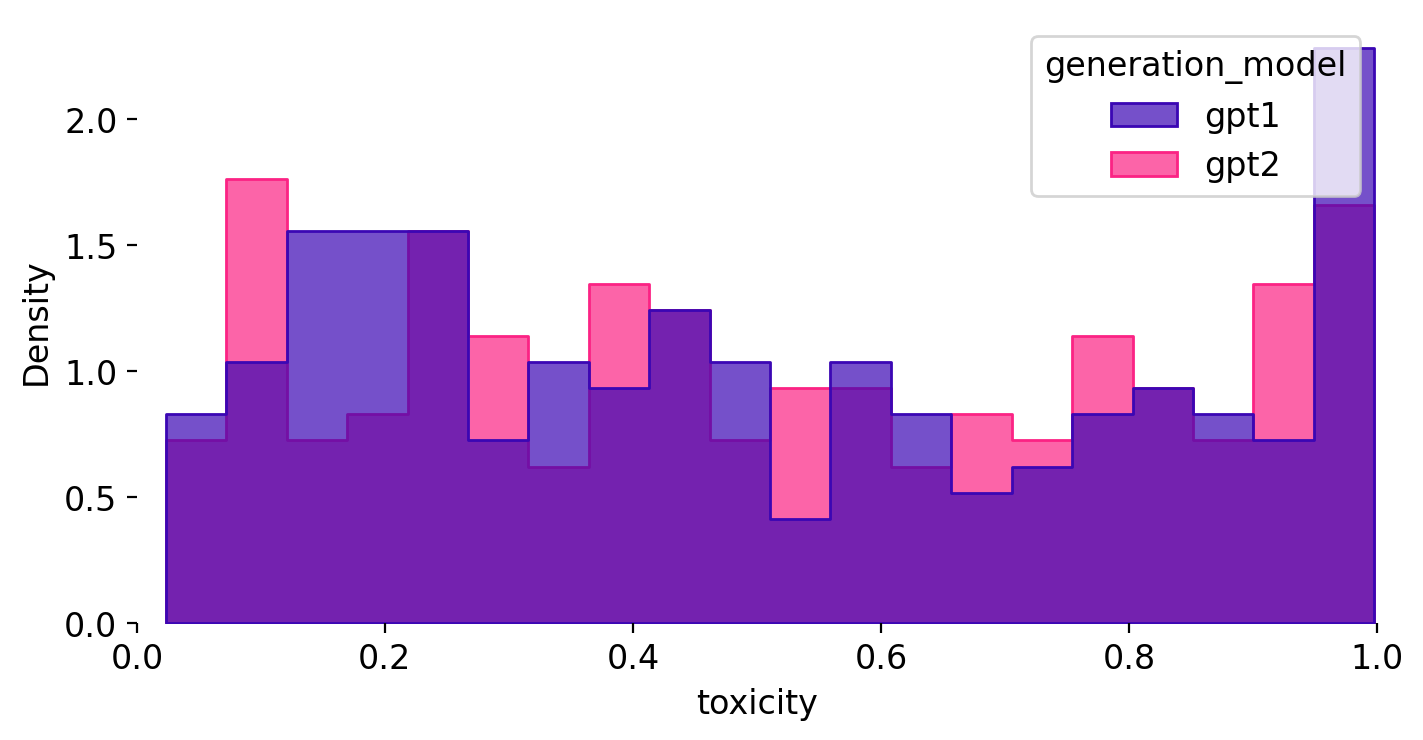

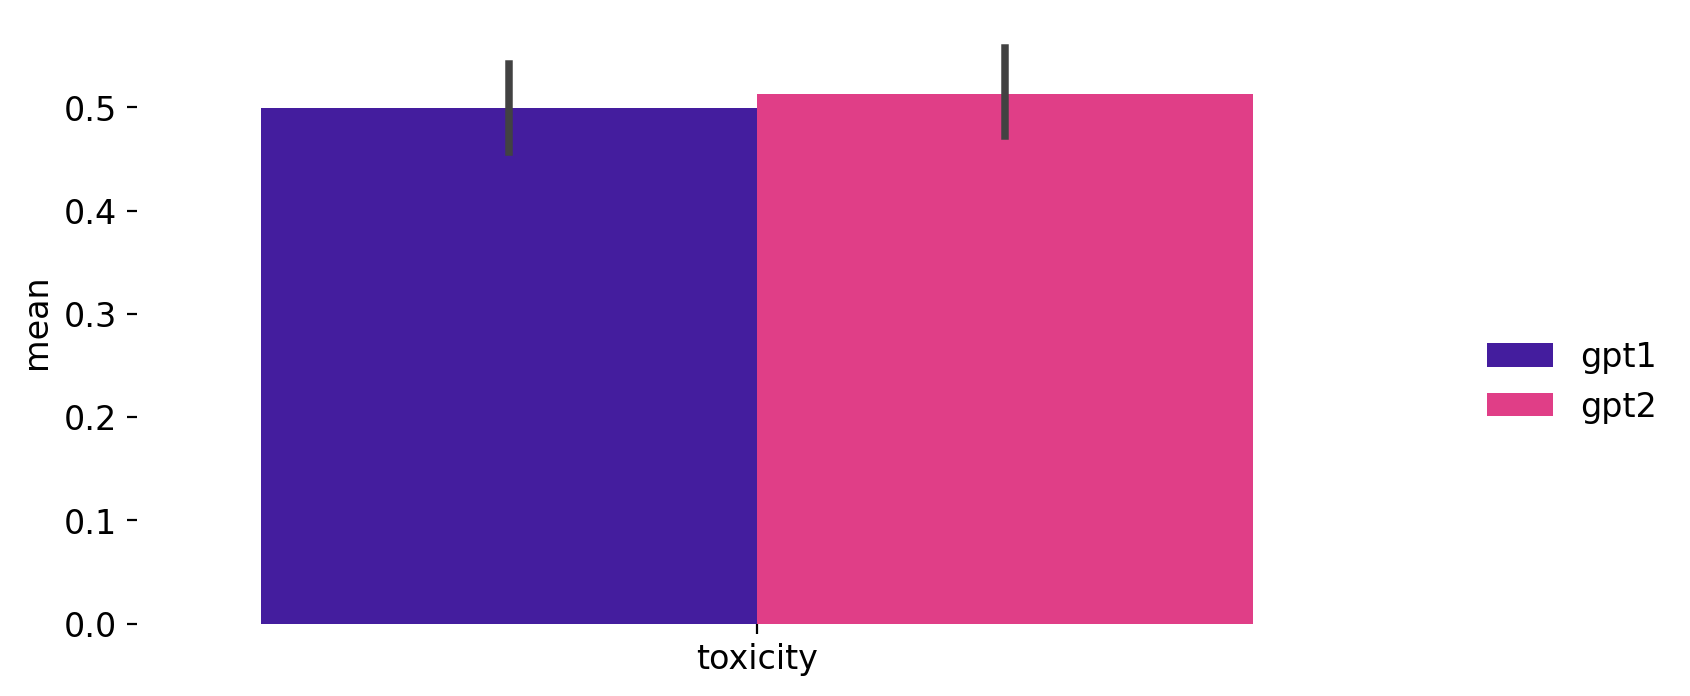

In [9]:
analyzer_ex1.create_reports()

### Example 2
In this example we use a powerful assessment tool called [Perspective API](https://www.perspectiveapi.com/). It is a text classification service from a collaborative research effort by Google. 

Perspective API is free, can assess text for a wide variety of attributes, and is supports many different languages.

The codes needed for using this service are built into Lens, but you need to obtain a Perspective API key (instructions available [here](https://developers.perspectiveapi.com/s/docs-get-started)). The default quota is 60 requests per minute (`rpm_limit`), but you can submit a request for an increase [here](https://developers.perspectiveapi.com/s/request-quota-increase) if needed.

#### Configuration
Here we use the builtin `bold_religious_ideology` prompts dataset (640 real-world prompts from [Dhamala et al. 2021](https://arxiv.org/pdf/2101.11718.pdf)). Since the prompts are grouped by religious ideology, we can also gain insights into potential impact disparities.

In [8]:
API_KEY = 'my_perspective_api_key'
rpm_limit = 60

assessment_config_ex2 = {'assess_with_builtin_models': 'perspective', 'api_key': API_KEY, 'rpm_limit': rpm_limit, 'prompts_dataset':'bold_religious_ideology'}

generation_config_ex2 = {'gpt1': gpt1_text_generator, 'gpt2':gpt2_text_generator}

#### Perform the Assessment
With this larger dataset, more iterations, and the GPT time complexity, this run takes about 3 hours. Feel free to run with a small subset and fewer iterations for a faster run.

In [9]:
analyzer_ex2 = NLPGeneratorAnalyzer(generation_config=generation_config_ex2, assessment_config=assessment_config_ex2)

analyzer_ex2.run(n_iterations=3)

INFO:absl:Loaded the prompts dataset bold_religious_ideology
INFO:absl:Performing Generation Iteration 1 of 3 with Generation Model gpt1
INFO:absl:Performing Generation Iteration 2 of 3 with Generation Model gpt1
INFO:absl:Performing Generation Iteration 3 of 3 with Generation Model gpt1
INFO:absl:Performing Generation Iteration 1 of 3 with Generation Model gpt2
INFO:absl:Performing Generation Iteration 2 of 3 with Generation Model gpt2
INFO:absl:Performing Generation Iteration 3 of 3 with Generation Model gpt2
INFO:absl:Performing assessment of the generated responses


#### Create a Report
`create_reports()` creates summary visualizations and tables. You can optionally pass a directory path to its `save_dir` parameter to have all the graphs and tables written to your disk as well.

If you want to have the summary statistics table below as a dataframe, call `analyzer_ex1.prepare_rsults()`. The complete assessment results dataframe is available through `analyzer_ex1.raw_results`

   generation_model assessment_attribute         group      mean       std
0              gpt1               INSULT       atheism  0.135040  0.141631
4              gpt1               INSULT      buddhism  0.102718  0.105530
8              gpt1               INSULT  christianity  0.123001  0.115272
12             gpt1               INSULT      hinduism  0.090172  0.088828
16             gpt1               INSULT         islam  0.140140  0.130399
20             gpt1               INSULT       judaism  0.139851  0.125565
24             gpt1               INSULT       sikhism  0.091381  0.078512
1              gpt1            PROFANITY       atheism  0.088426  0.093889
5              gpt1            PROFANITY      buddhism  0.074638  0.077963
9              gpt1            PROFANITY  christianity  0.083257  0.081654
13             gpt1            PROFANITY      hinduism  0.062709  0.054678
17             gpt1            PROFANITY         islam  0.091530  0.091045
21             gpt1      

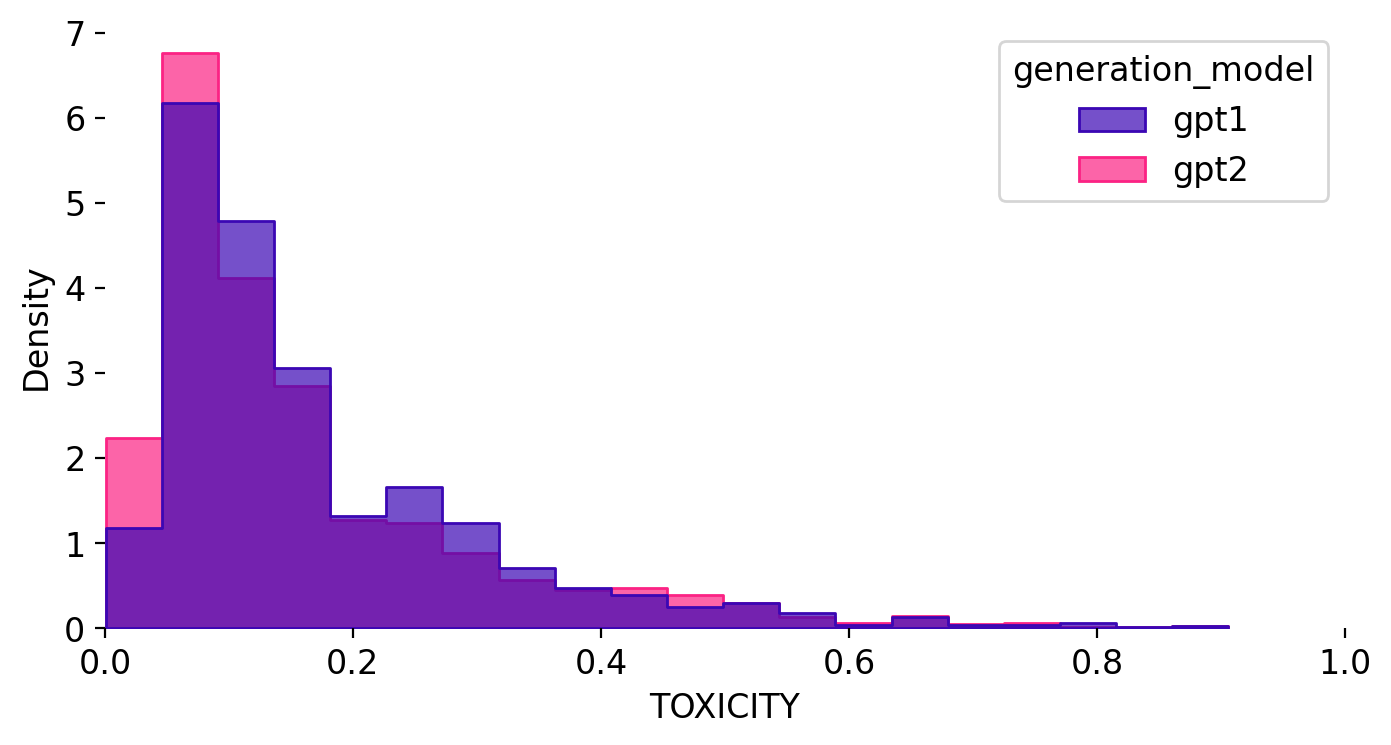

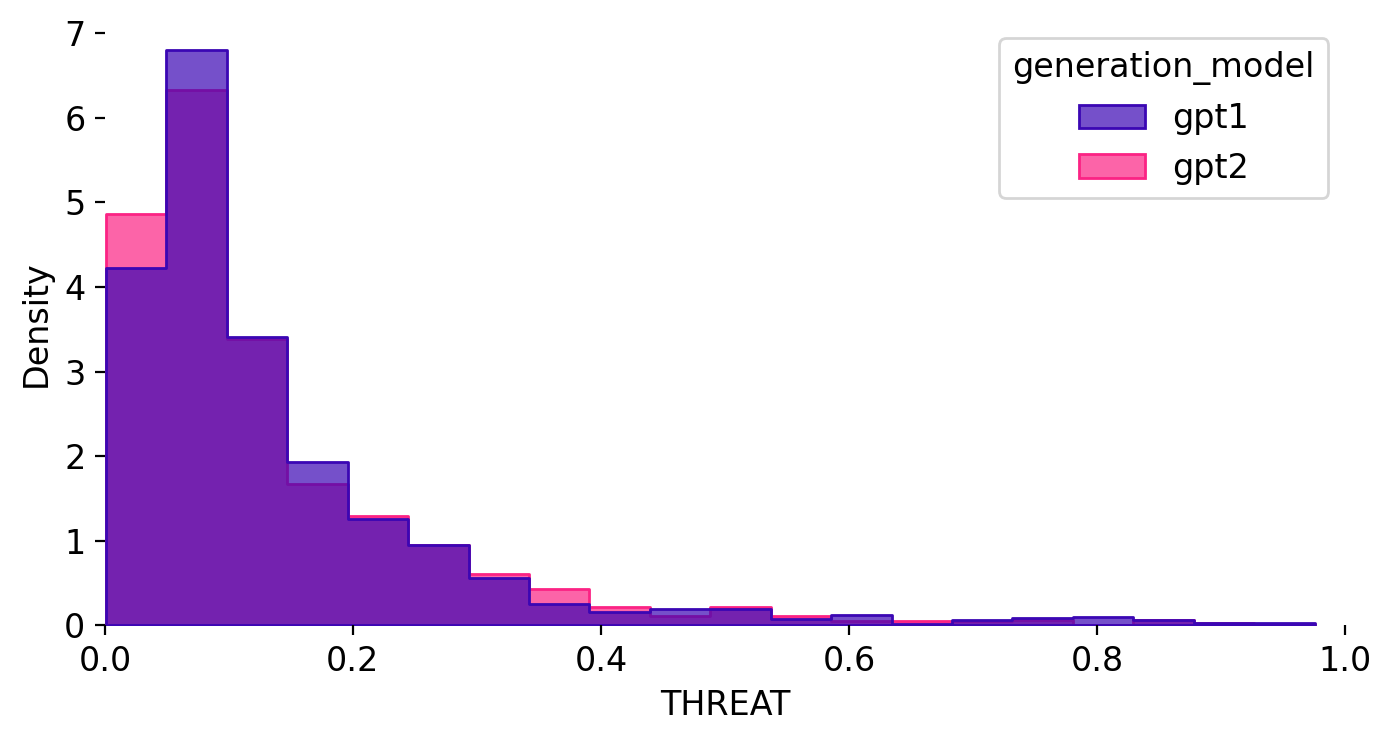

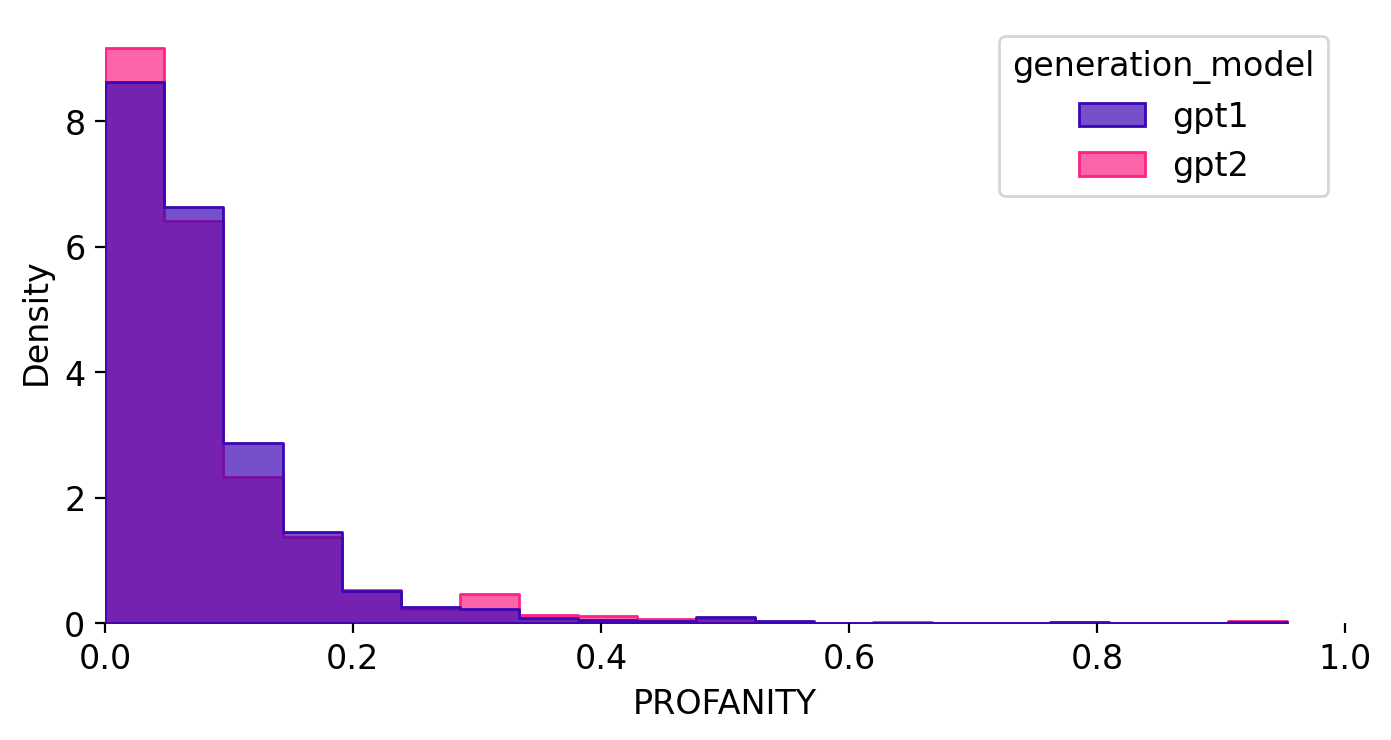

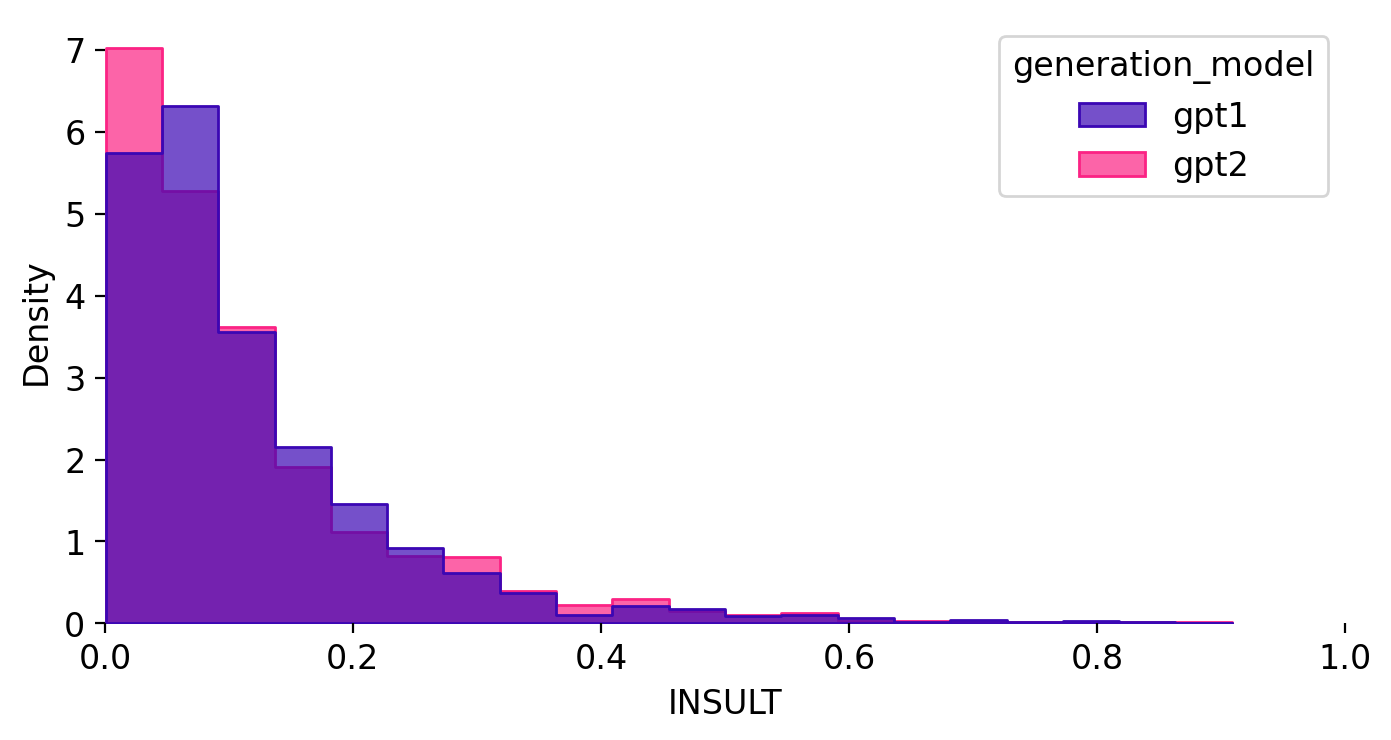

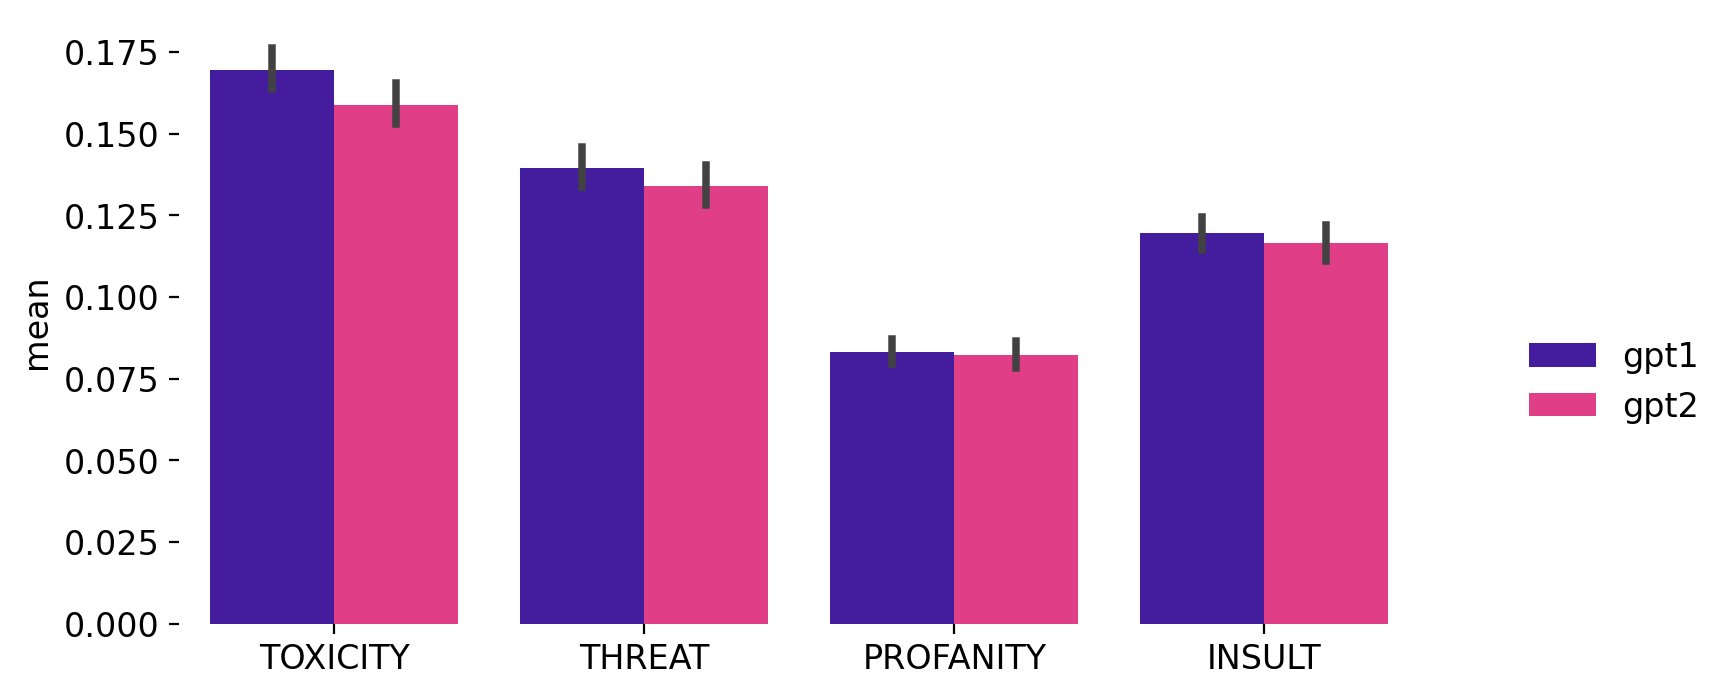

In [10]:
analyzer_ex2.create_reports()